Author: Zhile Xu

UUN: s2500393

In [1]:
import os
import glob
import spacy
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
from collections import Counter
import random
import warnings
import pyLDAvis.gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

# set up the environment
pyLDAvis.enable_notebook()
random.seed(123)
# turn off depreciation warnings and future warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# load spacy model
nlp = spacy.load("en_core_web_lg")

In [3]:
# function to load data
def load_data(base_dir):
    data = []
    labels = []
    files = []
    for label in ['positive', 'negative']:
        for filepath in glob.glob(os.path.join(base_dir, label, '*.txt')):
            with open(filepath, 'r', encoding='utf-8') as file:
                data.append(file.read())
                labels.append(1 if label == 'positive' else 0)
                files.append(filepath)
                
    return data, labels, files

In [4]:
# load training data
train_data, train_labels, train_files = load_data('data/train')

## Preprocess the Data

In [5]:
# preprocess the texts
def preprocess_texts(texts):
    docs = [nlp(text) for text in texts]
    return docs

# preprocess the training data
docs = preprocess_texts(train_data)


In [6]:
# function to remove stopwords and punctuation
def remove_stopwords_punctuation(doc):
    # remove stopwords and punctuation
    doc = [token for token in doc if not token.is_stop and not token.is_punct]
    # remove "\n", "Mr", "Mrs", "Miss" and "Ms"
    doc = [token for token in doc if token.text not in ['\n', 'Mr', 'Mrs', 'Miss', 'Ms']]
    # remove single characters
    doc = [token for token in doc if len(token.text) > 1]
    # removr numbers
    doc = [token for token in doc if not token.text.isnumeric()]
    return doc

#  lowercase and lemmatise the tokens
def lowercase_and_lemmatise(docs):
    lemmatised_docs = []
    for doc in docs:
        lemmatised_tokens = [token.lemma_.lower() for token in doc]
        
        lemmatised_docs.append(lemmatised_tokens)
    return lemmatised_docs

# remove stopwords and punctuation
cleaned_docs = [remove_stopwords_punctuation(doc) for doc in docs]
# lowercase and lemmatise the tokens
lemmatised_docs = lowercase_and_lemmatise(cleaned_docs)

## Topic Modelling

In [7]:
# function to build a topic model (LDA)
def build_topic_model(docs, dictionary, corpus, num_topics):

    # train an LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, iterations=50,
                          num_topics=num_topics, passes=20, random_state=123)

    # compute the coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=docs, 
                                     dictionary=dictionary, coherence='c_v')

    print(f'Num Topics: {num_topics}, Coherence Score: {coherence_model.get_coherence()}')

    return lda_model, coherence_model.get_coherence()


In [8]:
print("Topic model for the whole dataset")

# create a dictionary
dictionary = Dictionary(lemmatised_docs)

# filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in lemmatised_docs]

coherence = pd.DataFrame(index=range(2, 11), columns=['coherence'])
for num_topics in coherence.index:
    _, coherence_score = build_topic_model(lemmatised_docs, dictionary, corpus, num_topics)
    coherence.loc[num_topics, 'coherence'] = coherence_score

Topic model for the whole dataset
Num Topics: 2, Coherence Score: 0.297495445808965
Num Topics: 3, Coherence Score: 0.37234277962622425
Num Topics: 4, Coherence Score: 0.3849982409351189
Num Topics: 5, Coherence Score: 0.4004590940198932
Num Topics: 6, Coherence Score: 0.410611453934333
Num Topics: 7, Coherence Score: 0.4230927689925639
Num Topics: 8, Coherence Score: 0.4119071167157601
Num Topics: 9, Coherence Score: 0.41777123344624534
Num Topics: 10, Coherence Score: 0.4230259314285273


The optimal number of topics is: 7


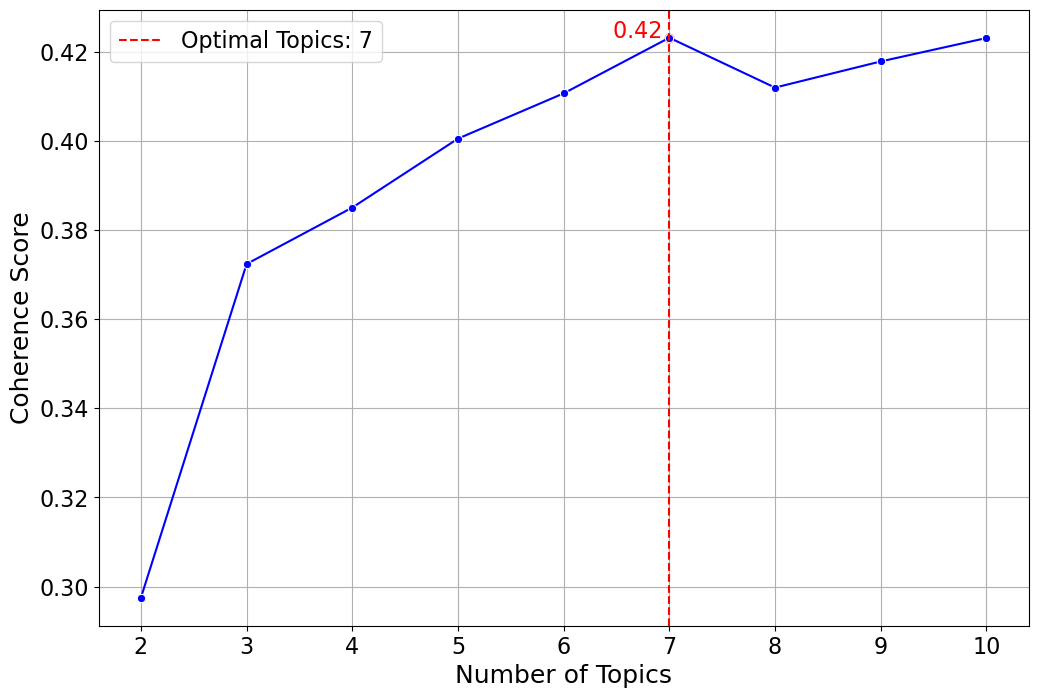

In [9]:
# find the optimal number of topics
optimal_num_topics = coherence['coherence'].idxmax()
print(f'The optimal number of topics is: {optimal_num_topics}')

# plot the coherence scores
def plot_coherence(coherence):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=coherence, x=coherence.index, y='coherence', marker='o', color='b')
    # plt.title('Coherence Score vs. Number of Topics', fontsize=16)
    plt.xlabel('Number of Topics', fontsize=18)
    plt.ylabel('Coherence Score', fontsize=18)
    plt.xticks(coherence.index, fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    
    # add a vertical line for the optimal number of topics
    optimal_score = coherence.loc[optimal_num_topics, 'coherence']
    plt.axvline(x=optimal_num_topics, color='r', linestyle='--', label=f'Optimal Topics: {optimal_num_topics}')
    plt.scatter(optimal_num_topics, optimal_score, color='r')
    plt.text(optimal_num_topics, optimal_score, f'{optimal_score:.2f} ', horizontalalignment='right', fontsize=16, color='r')
    
    plt.legend(fontsize=16)
    # save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig('plots/coherence_score.png', dpi=300)
    plt.show()


plot_coherence(coherence)

In [10]:
# train the LDA model with the optimal number of topics
lda_model, _ = build_topic_model(lemmatised_docs, dictionary, corpus, optimal_num_topics)

Num Topics: 7, Coherence Score: 0.4230927689925639


In [11]:
# print the words in each topic
for topic_id in range(optimal_num_topics):
    # get the words in the topic
    print(f'Topic {topic_id}: {lda_model.print_topic(topic_id)}')

Topic 0: 0.032*"repair" + 0.016*"car" + 0.015*"vehicle" + 0.015*"ageas" + 0.010*"garage" + 0.010*"decline" + 0.009*"phone" + 0.009*"fairmead" + 0.008*"report" + 0.008*"repairer"
Topic 1: 0.036*"axa" + 0.017*"medical" + 0.014*"treatment" + 0.014*"vitality" + 0.011*"misrepresentation" + 0.010*"decline" + 0.008*"question" + 0.006*"illness" + 0.006*"relevant" + 0.006*"dog"
Topic 2: 0.051*"car" + 0.022*"value" + 0.022*"admiral" + 0.021*"advantage" + 0.018*"valuation" + 0.017*"esure" + 0.016*"vehicle" + 0.014*"settlement" + 0.012*"loss" + 0.011*"guide"
Topic 3: 0.023*"aviva" + 0.022*"property" + 0.015*"work" + 0.015*"repair" + 0.010*"contractor" + 0.010*"water" + 0.009*"report" + 0.009*"loss" + 0.009*"accredited" + 0.008*"home"
Topic 4: 0.015*"legal" + 0.014*"solicitor" + 0.013*"gas" + 0.012*"boiler" + 0.011*"engineer" + 0.011*"amtrust" + 0.011*"leak" + 0.010*"british" + 0.008*"firm" + 0.007*"liability"
Topic 5: 0.027*"uki" + 0.016*"rsa" + 0.012*"delay" + 0.012*"cancel" + 0.011*"ipa" + 0.009

In [17]:
# create a dictionary to map the topic id to a description of the topic
dict_topics = {
    0: "Vehicle Repairs and Services",
    1: "Health and Pet Insurance Claims",
    2: "Car Insurance Valuation and Settlement",
    3: "Property Insurance and Repairs",
    4: "Home Service and Legal Issues",
    5: "Travel Insurance Delays and Cancellations",
    6: "Insurance Premiums and Renewal Policies"
}


# print 5 document text with their topics
for i in range(5):
    # choose a random document
    doc_id = random.randint(0, len(lemmatised_docs))
    # get the document's topic distribution
    topic_distribution = lda_model.get_document_topics(corpus[doc_id])
    # get the topic with the highest probability
    topic_id = max(topic_distribution, key=lambda x: x[1])[0]
    # print the document text and the topic
    print(f'File: {train_files[doc_id]}')
    print(f'Topic: {topic_id} - {dict_topics[topic_id]}')
    print(train_data[doc_id][:500])
    print()

File: data/train/negative/DRN-4766843.txt
Topic: 4 - Home Service and Legal Issues
The complaint
Mrs H's complaint is about a claim she made on her DAS Legal Expenses Insurance Company Limited (DAS') legal expenses insurance policy. Mrs H feels that DAS treated her unfairly. 
What happened
Mrs H made a claim on her DAS legal expenses insurance policy for cover to pursue a claim in clinical negligence. DAS appointed a panel firm to consider her claim, but they declined to act due to a conflict of interest. DAS instructed a second firm to act for Mrs H instead. They assessed her

File: data/train/negative/DRN-4837166.txt
Topic: 1 - Health and Pet Insurance Claims
The complaint
The estate of Mr M has complained that Legal and General Assurance Society Limited (L&G') has unfairly declined a claim. 
What happened
The late Mr M bought a life insurance policy in late 2014. He unfortunately passed away and a claim was made on his policy. But L&G said he hadn't answered a question about advice 

### Wordclouds

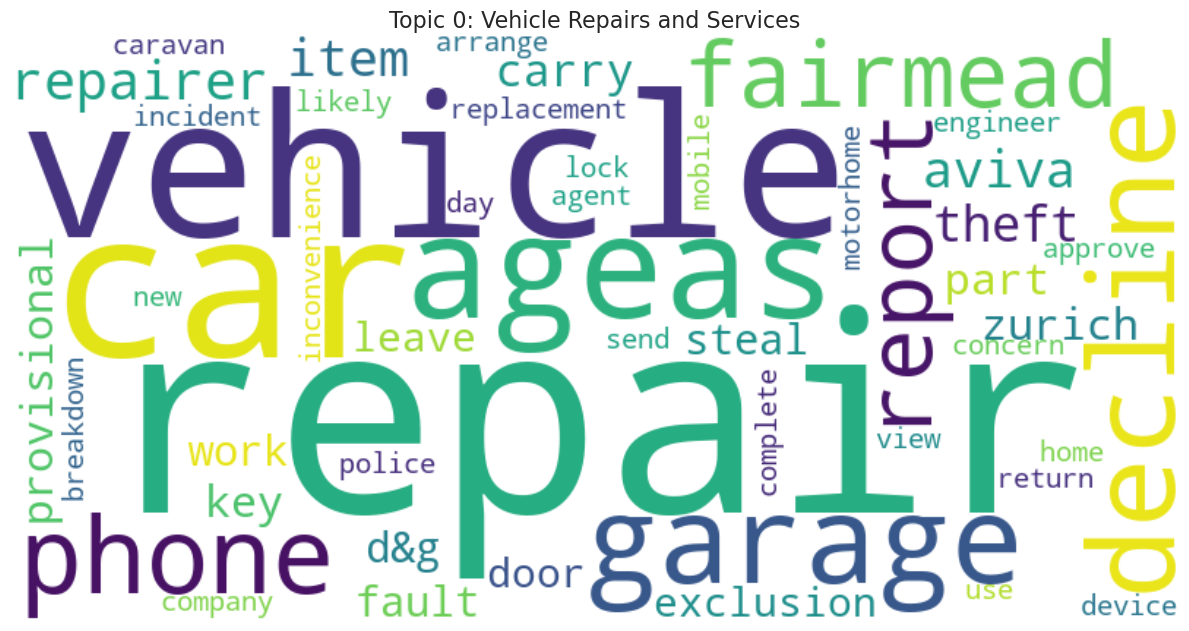

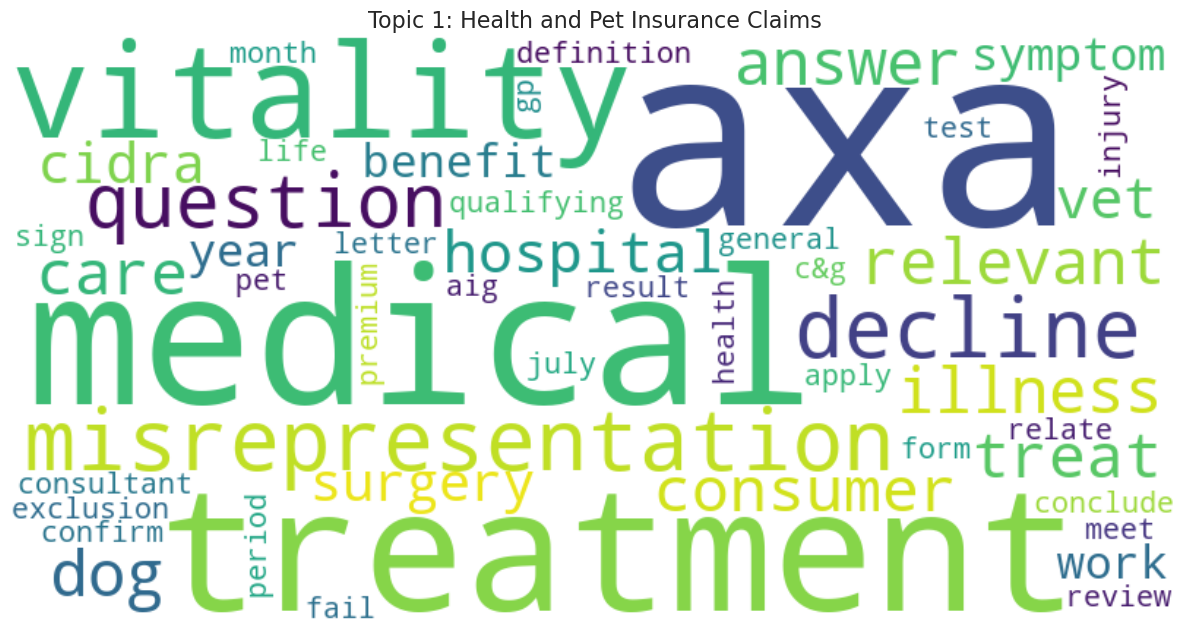

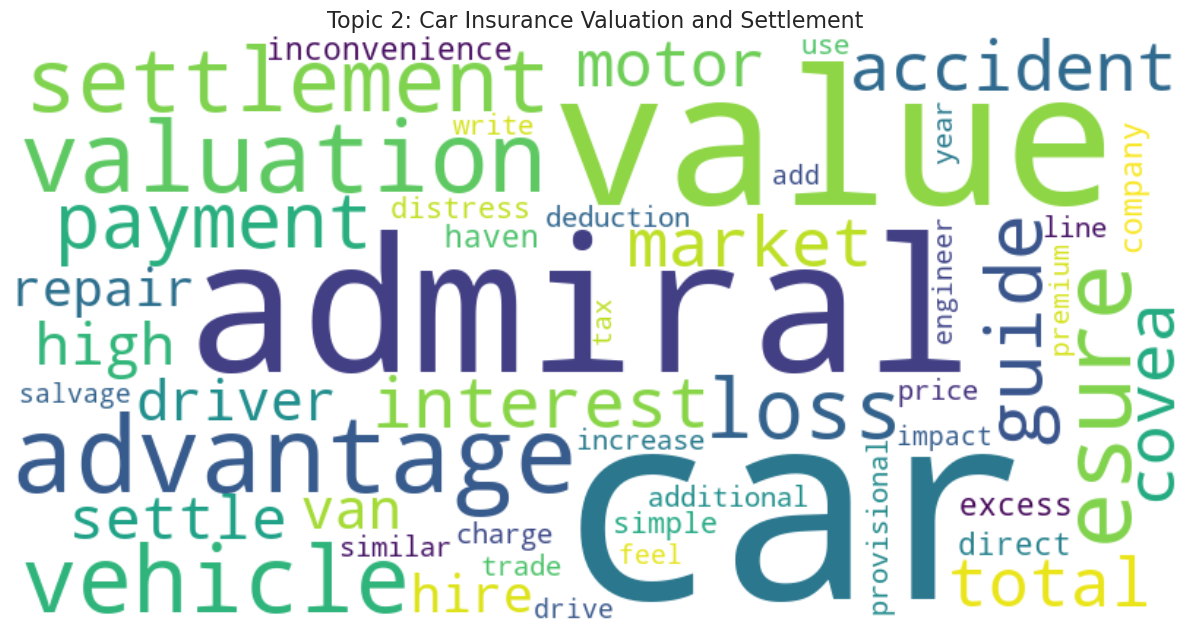

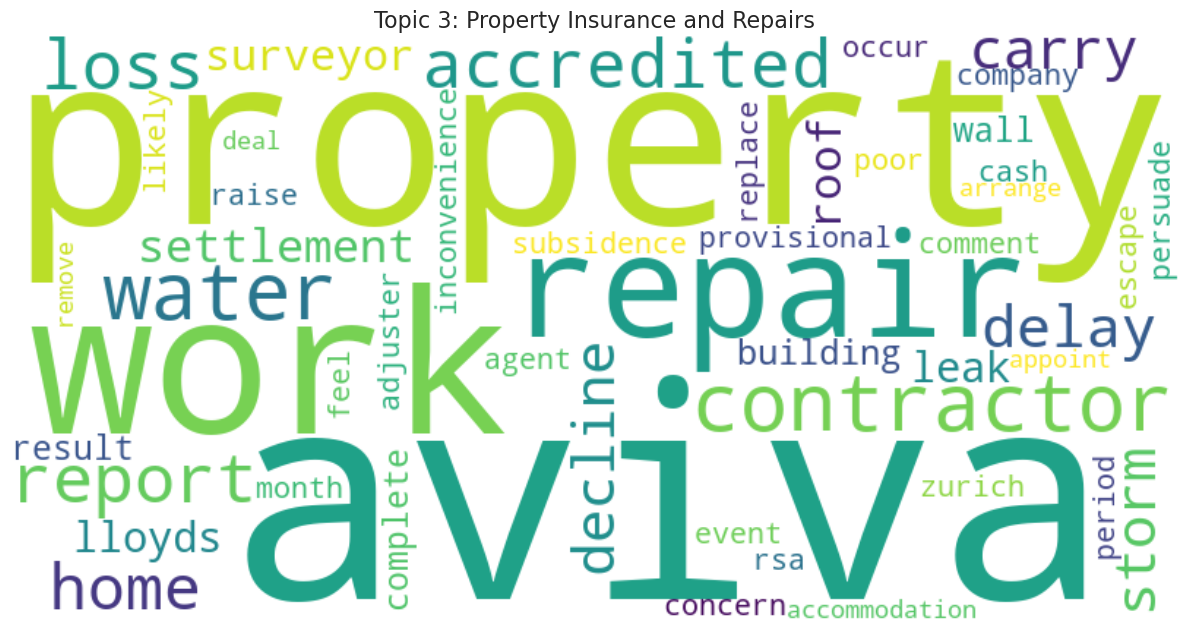

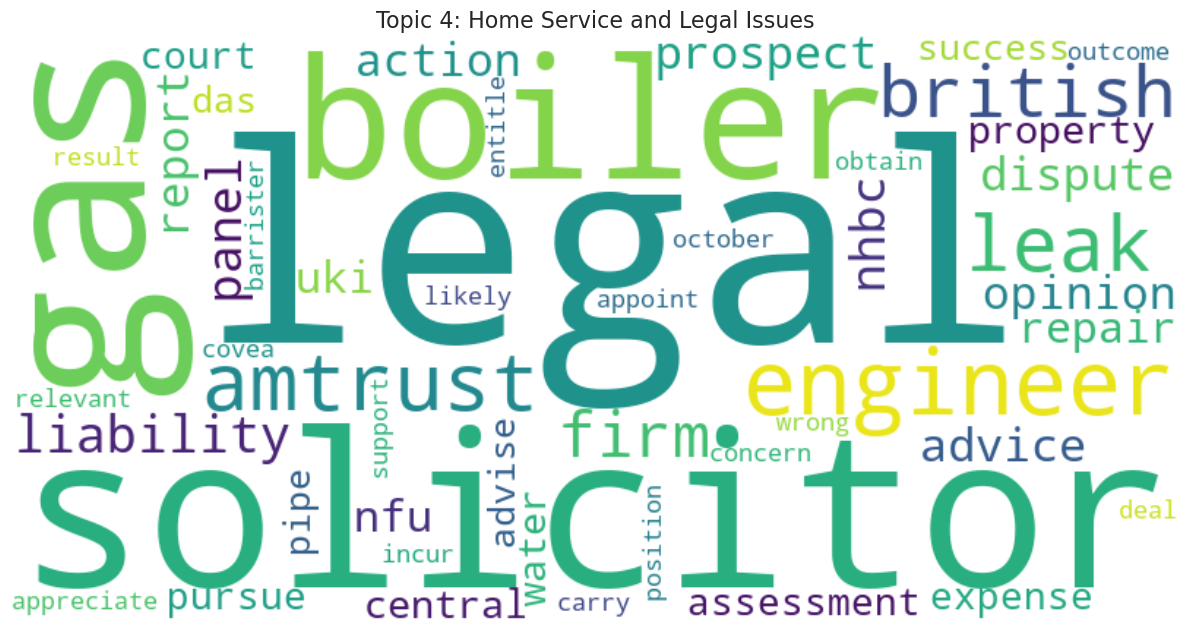

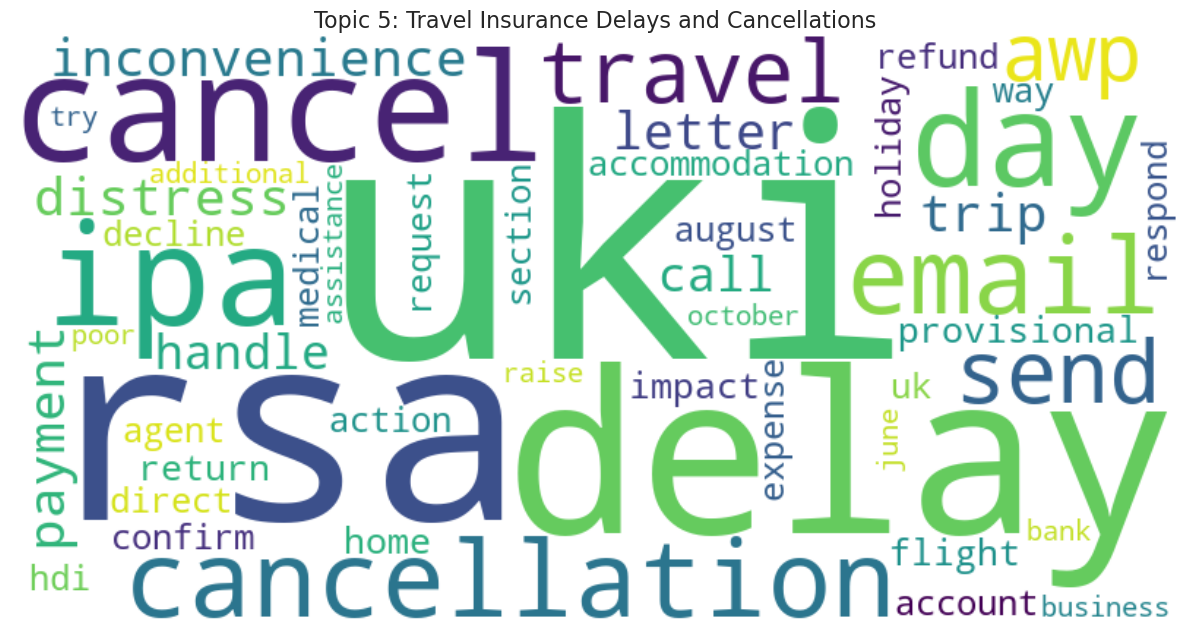

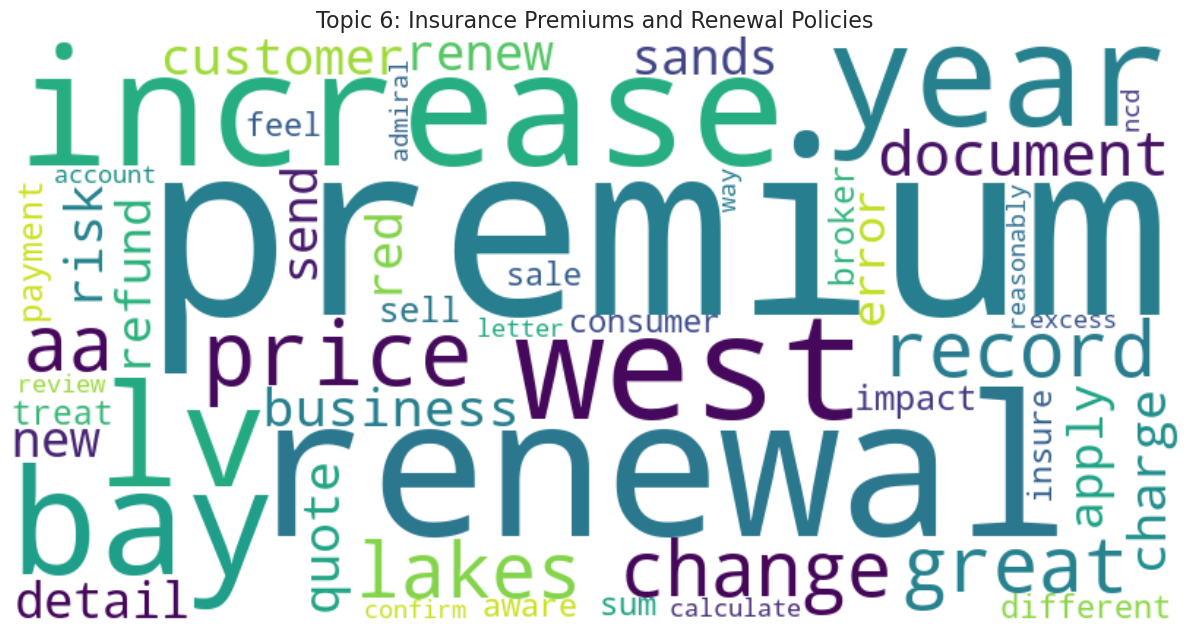

In [36]:
dict_topics = {
    0: "Vehicle Repairs and Services",
    1: "Health and Pet Insurance Claims",
    2: "Car Insurance Valuation and Settlement",
    3: "Property Insurance and Repairs",
    4: "Home Service and Legal Issues",
    5: "Travel Insurance Delays and Cancellations",
    6: "Insurance Premiums and Renewal Policies"
}

# draw a word cloud for a topic
def draw_word_cloud(lda_model, topic_id, dict_topics=dict_topics):
    # get the words in the topic
    words = lda_model.show_topic(topic_id, topn=50)
    
    # create a dictionary from the words
    word_dict = {word: score for word, score in words}
    
    # create the word cloud
    word_cloud = WordCloud(width=800, height=400, background_color='white',colormap='viridis').generate_from_frequencies(word_dict)
    
    # plot the word cloud
    plt.figure(figsize=(12, 8))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_id}: {dict_topics[topic_id]}', fontsize=16)
    plt.tight_layout()

    if not os.path.exists('plots'):
        os.makedirs('plots')

    plt.savefig(f'plots/topic-{topic_id}-word-cloud.png', dpi=300)
    plt.show()

# draw the word cloud for the topics
for topic_id in range(7):
    draw_word_cloud(lda_model, topic_id)


### Distribution of topics in the dataset

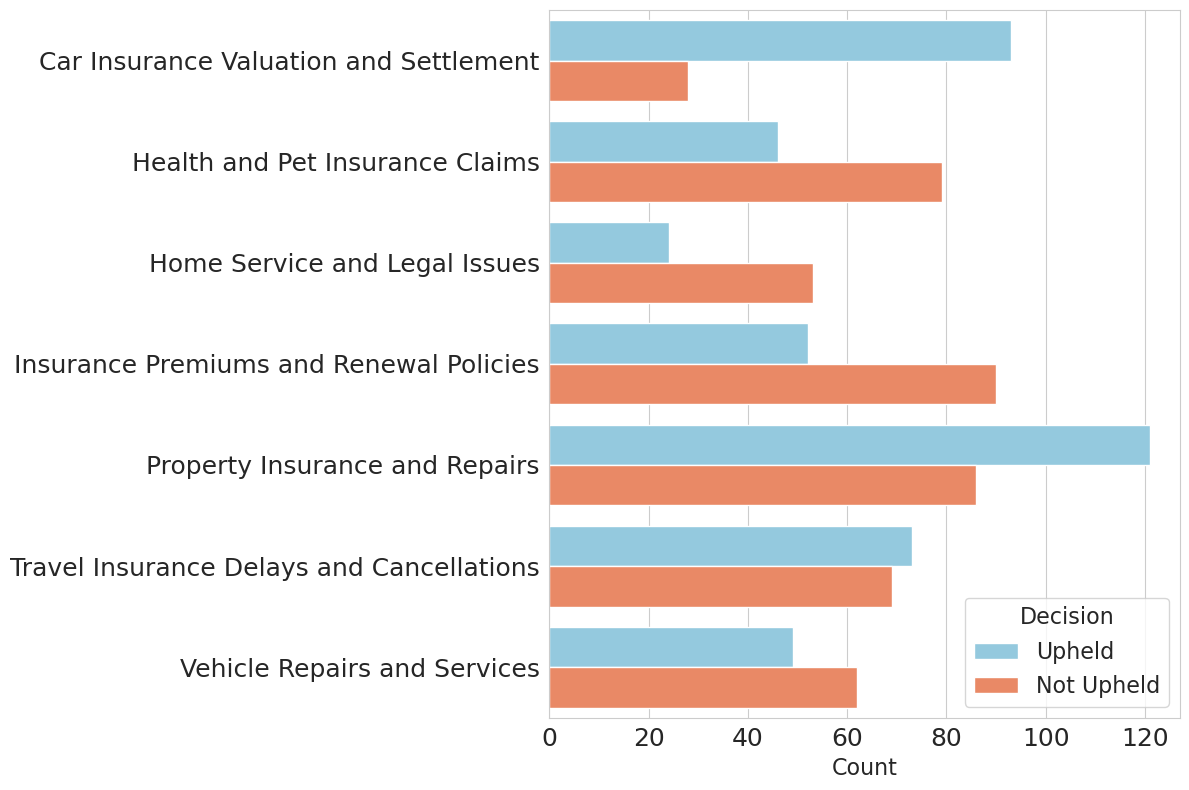

In [33]:
# assign topics to the documents
topics = [max(lda_model[doc], key=lambda x: x[1])[0] for doc in corpus]

# create a dataframe with the topics
df_topics = pd.DataFrame({'topic': topics, 'topic_label': train_labels})

def plot_topic_distribution(df_topics, dict_topics):
    df_topics['topic_label'] = df_topics['topic_label'].map({1: 'Upheld', 0: 'Not Upheld'})
    df_topics['topic'] = df_topics['topic'].map(dict_topics)
    
    df_topics.sort_values('topic', inplace=True)

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8))
    sns.countplot(y='topic', hue='topic_label', data=df_topics, palette={'Upheld': 'skyblue', 'Not Upheld': 'coral'})
    
    # plt.title('Distribution of Topics in the Dataset', fontsize=16)
    # plt.ylabel('Topic', fontsize=16)
    plt.xlabel('Count', fontsize=16)
    plt.ylabel('', fontsize=16)
    legend = plt.legend(title='Decision', fontsize=16, title_fontsize='16', loc='lower right')
    frame = legend.get_frame()


    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.tight_layout()

    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig('plots/topic-distribution.png', dpi=300)
    plt.show()


plot_topic_distribution(df_topics, dict_topics)

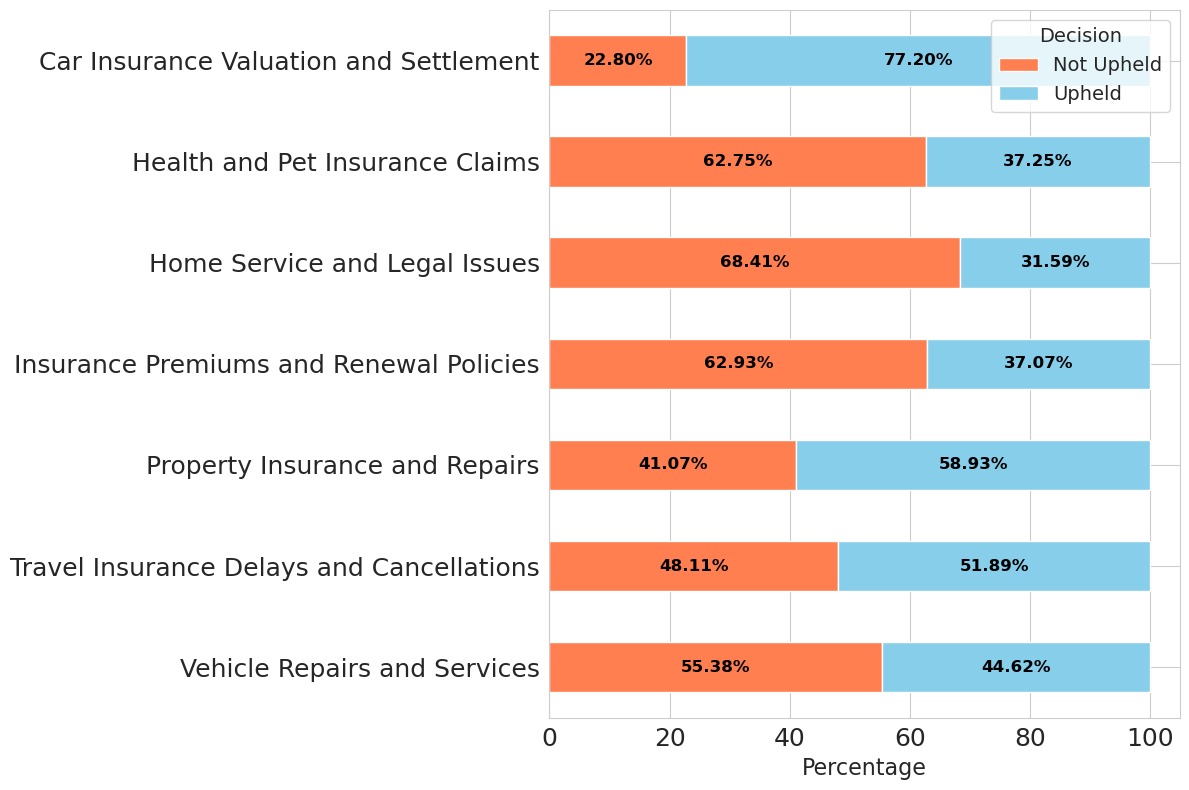

In [32]:
# calculate the topic distribution for each label (percentage)
topic_distribution = df_topics.groupby('topic_label')['topic'].value_counts(normalize=True).unstack()
# dive the topic distribution by the sum of the values in each column
topic_distribution = topic_distribution.div(topic_distribution.sum(axis=0), axis=1)
# multiply the values by 100 to get percentages
topic_distribution = topic_distribution * 100

def plot_distribution_percent(df):

    sns.set_style("whitegrid")
    ax = df.T.plot(kind='barh', stacked=True, figsize=(12, 8), 
                   color={'Upheld': 'skyblue', 'Not Upheld': 'coral'},
                     linewidth=1)

    # plt.title('Distribution of Topics Across Different Insurance Types', fontsize=16, color='#333333')
    plt.xlabel('Percentage', fontsize=16)
    plt.ylabel('', fontsize=16)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)

    # improve legend aesthetics
    legend = plt.legend(title='Decision', fontsize=14, title_fontsize='14', loc='upper right')

    # annotate percentage values on the bars
    for p in ax.patches:
        width = p.get_width()
        label_text = f'{width:.2f}%'
        label_x_pos = p.get_x() + width / 2
        label_y_pos = p.get_y() + p.get_height() / 2
        ax.annotate(label_text, (label_x_pos, label_y_pos), ha='center',
                     va='center', fontsize=12, color='black', fontweight='bold')

    # reverse the y-axis to have the top values at the top
    plt.gca().invert_yaxis()

    plt.tight_layout()

    # save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig('plots/topic-distribution-percent.png', dpi=300)
    
    # show plot
    plt.show()


plot_distribution_percent(topic_distribution)

In [16]:
# visualise the topics 
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.038461  0.117331       1        1  25.015358
5      0.027868 -0.060134       2        1  14.521184
6     -0.027947 -0.092111       3        1  13.317505
1      0.133491 -0.103956       4        1  13.039152
2     -0.181739 -0.034926       5        1  12.989759
0     -0.046090  0.074539       6        1  11.770326
4      0.055956  0.099257       7        1   9.346716, topic_info=          Term         Freq        Total Category  logprob  loglift
612        car  3152.000000  3152.000000  Default  30.0000  30.0000
1763       axa  1642.000000  1642.000000  Default  29.0000  29.0000
1643       uki  1559.000000  1559.000000  Default  28.0000  28.0000
146     repair  3128.000000  3128.000000  Default  27.0000  27.0000
1506     aviva  2356.000000  2356.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
297      water   147.060468  1005.530307   Topic7  -5.4026   0.4477
147     report   166.390838  1716.395745   Topic7  -5.2791   0.0365
1643       uki   158.337568  1559.026073   Topic7  -5.3287   0.0831
146     repair   161.583483  3128.561764   Topic7  -5.3084  -0.5932
135   property   153.277115  2266.758299   Topic7  -5.3612  -0.3237

[480 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2695      3  0.078444  75,000
2695      5  0.862879  75,000
906       1  0.125848      aa
906       2  0.002678      aa
906       3  0.870229      aa
...     ...       ...     ...
2041      1  0.499891  zurich
2041      2  0.140647  zurich
2041      3  0.016945  zurich
2041      5  0.001695  zurich
2041      6  0.340603  zurich

[1566 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 7, 2, 3, 1, 5])